Ventanas guardadas en Dataset1_roads/windows\10078675_15
Ventanas guardadas en Dataset1_roads/windows\10228675_15
Ventanas guardadas en Dataset1_roads/windows\10228705_15
Ventanas guardadas en Dataset1_roads/windows\10228720_15
Ventanas guardadas en Dataset1_roads/windows\10228735_15
Ventanas guardadas en Dataset1_roads/windows\10228750_15
Ventanas guardadas en Dataset1_roads/windows\10378675_15
Ventanas guardadas en Dataset1_roads/windows\10378690_15
Ventanas guardadas en Dataset1_roads/windows\10378705_15
Ventanas guardadas en Dataset1_roads/windows\10378720_15
Ventanas guardadas en Dataset1_roads/windows\10378735_15
Ventanas guardadas en Dataset1_roads/windows\10378750_15
Ventanas guardadas en Dataset1_roads/windows\10378765_15
Ventanas guardadas en Dataset1_roads/windows\10528675_15
Ventanas guardadas en Dataset1_roads/windows\10528690_15
Ventanas guardadas en Dataset1_roads/windows\10528705_15
Ventanas guardadas en Dataset1_roads/windows\10528720_15
Ventanas guardadas en Dataset1_

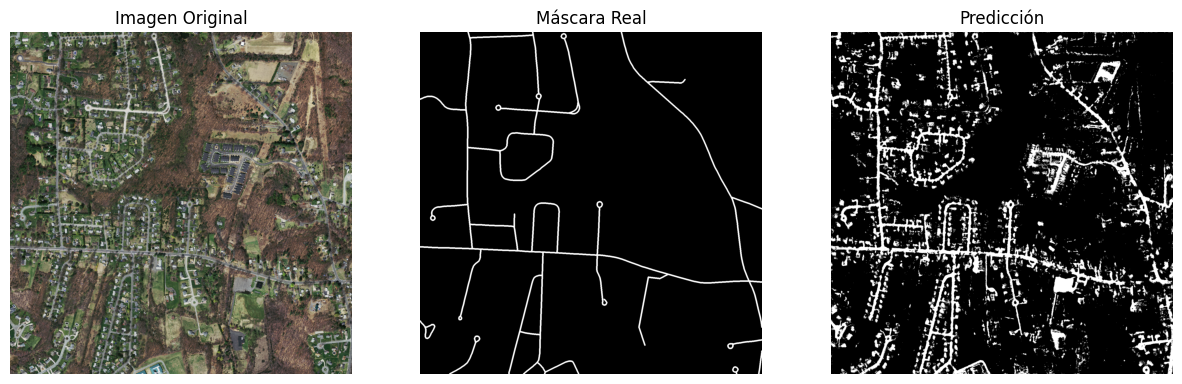

In [ ]:
import cv2
import numpy as np
import os
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# 1. Función para cargar imágenes y máscaras
def load_images_and_masks(image_dir, mask_dir):
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.tiff') or f.endswith('.tif')])
    mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('.tiff') or f.endswith('.tif')])
    
    images, masks, ids = [], [], []
    for img_file, mask_file in zip(image_files, mask_files):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if img is not None and mask is not None:
            images.append(img)
            masks.append(mask)
            ids.append(os.path.splitext(img_file)[0])
    return images, masks, ids

# 2. Función para extraer ventanas con padding
def extract_window(image, center, window_size):
    half = window_size // 2
    padded_window = np.zeros((window_size, window_size, 3), dtype=np.uint8)
    x, y = center
    for i in range(-half, half):
        for j in range(-half, half):
            img_x, img_y = x + i, y + j
            if 0 <= img_x < image.shape[0] and 0 <= img_y < image.shape[1]:
                padded_window[i + half, j + half] = image[img_x, img_y]
    return padded_window

# 3. Guardar ventanas en directorios organizados
def save_windows(X, Y, img_id, output_dir, window_size):
    img_dir = os.path.join(output_dir, img_id)
    carretera_dir = os.path.join(img_dir, "Carretera")
    no_carretera_dir = os.path.join(img_dir, "No_Carretera")
    os.makedirs(carretera_dir, exist_ok=True)
    os.makedirs(no_carretera_dir, exist_ok=True)
    
    for idx, (window, label) in enumerate(zip(X, Y)):
        filename = f"win_{idx}_{label}.png"
        path = os.path.join(carretera_dir if label == 1 else no_carretera_dir, filename)
        reshaped_window = window.reshape((window_size, window_size, 3))
        cv2.imwrite(path, reshaped_window)
    print(f"Ventanas guardadas en {img_dir}")

# 4. Generar datos para entrenamiento
def generate_training_data(images, masks, ids, window_size, num_samples, output_dir):
    X_train, Y_train = [], []
    for img, mask, img_id in zip(images, masks, ids):
        white_pixels = get_white_pixels(mask, num_samples)
        black_pixels = get_black_pixels(mask, num_samples)
        for pixel in white_pixels + black_pixels:
            window = extract_window(img, pixel, window_size).flatten()
            label = 1 if mask[pixel[0], pixel[1]] >= 128 else 0
            X_train.append(window)
            Y_train.append(label)
        save_windows(X_train, Y_train, img_id, output_dir, window_size)
    return np.array(X_train), np.array(Y_train)

# 5. Funciones auxiliares
import random

# Función para obtener píxeles blancos (carretera)
def get_white_pixels(mask, size):
    pixels_selected_white = []
    i = 0
    while i < size:
        x = random.randint(0, mask.shape[0] - 1)
        y = random.randint(0, mask.shape[1] - 1)
        # Verificar que el píxel sea blanco y no esté ya seleccionado
        if mask[x, y] >= 128 and [x, y] not in pixels_selected_white:
            pixels_selected_white.append([x, y])
            i += 1
    return pixels_selected_white

# Función para obtener píxeles negros (no carretera)
def get_black_pixels(mask, size):
    pixels_selected_black = []
    i = 0
    while i < size:
        x = random.randint(0, mask.shape[0] - 1)
        y = random.randint(0, mask.shape[1] - 1)
        # Verificar que el píxel sea negro y no esté ya seleccionado
        if mask[x, y] < 128 and [x, y] not in pixels_selected_black:
            pixels_selected_black.append([x, y])
            i += 1
    return pixels_selected_black


# 6. Entrenamiento del modelo Random Forest
def train_rf_model(X_train, Y_train):
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, Y_train)
    print("Modelo entrenado correctamente.")
    return model

# 7. Evaluar imágenes completas
def evaluate_on_image(model, image, mask, window_size):
    rows, cols = image.shape[:2]
    predictions = np.zeros((rows, cols), dtype=np.uint8)
    Y_true, Y_pred = [], []
    for i in range(rows):
        for j in range(cols):
            window = extract_window(image, (i, j), window_size).flatten()
            pred = model.predict([window])[0]
            predictions[i, j] = pred
            Y_true.append(1 if mask[i, j] >= 128 else 0)
            Y_pred.append(pred)
    print(classification_report(Y_true, Y_pred))
    print("Matriz de confusión:")
    print(confusion_matrix(Y_true, Y_pred))
    return predictions

# 8. Visualizar resultados
def visualize_predictions(image, mask, predictions):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Imagen Original")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.subplot(1, 3, 2)
    plt.title("Máscara Real")
    plt.imshow(mask, cmap='gray')
    plt.axis("off")
    plt.subplot(1, 3, 3)
    plt.title("Predicción")
    plt.imshow(predictions, cmap='gray')
    plt.axis("off")
    plt.show()

# Ejecución del pipeline completo
image_dir = "Dataset1_roads/sat"
mask_dir = "Dataset1_roads/gt"
output_dir = "Dataset1_roads/windows"

# Cargar datos
images, masks, ids = load_images_and_masks(image_dir, mask_dir)

# Generar datos de entrenamiento
X_train, Y_train = generate_training_data(images[:-1], masks[:-1], ids[:-1], window_size=16, num_samples=100, output_dir=output_dir)

# Entrenar modelo
model = train_rf_model(X_train, Y_train)

# Evaluar modelo en una imagen completa
predictions = evaluate_on_image(model, images[-1], masks[-1], window_size=16)

# Visualizar resultados
visualize_predictions(images[-1], masks[-1], predictions)


In [2]:
import cv2
import numpy as np
import os
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# 1. Función para cargar imágenes y máscaras
def load_images_and_masks(image_dir, mask_dir):
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.tiff') or f.endswith('.tif')])
    mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('.tiff') or f.endswith('.tif')])
    
    images, masks, ids = [], [], []
    for img_file, mask_file in zip(image_files, mask_files):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if img is not None and mask is not None:
            images.append(img)
            masks.append(mask)
            ids.append(os.path.splitext(img_file)[0])
    return images, masks, ids

# 2. Función para extraer ventanas con padding
def extract_window(image, center, window_size):
    half = window_size // 2
    padded_window = np.zeros((window_size, window_size, 3), dtype=np.uint8)
    x, y = center
    for i in range(-half, half):
        for j in range(-half, half):
            img_x, img_y = x + i, y + j
            if 0 <= img_x < image.shape[0] and 0 <= img_y < image.shape[1]:
                padded_window[i + half, j + half] = image[img_x, img_y]
    return padded_window

# 3. Guardar ventanas en directorios organizados
def save_windows(X, Y, img_id, output_dir, window_size):
    img_dir = os.path.join(output_dir, img_id)
    carretera_dir = os.path.join(img_dir, "Carretera")
    no_carretera_dir = os.path.join(img_dir, "No_Carretera")
    os.makedirs(carretera_dir, exist_ok=True)
    os.makedirs(no_carretera_dir, exist_ok=True)
    
    for idx, (window, label) in enumerate(zip(X, Y)):
        filename = f"win_{idx}_{label}.png"
        path = os.path.join(carretera_dir if label == 1 else no_carretera_dir, filename)
        reshaped_window = window.reshape((window_size, window_size, 3))
        cv2.imwrite(path, reshaped_window)
    print(f"Ventanas guardadas en {img_dir}")

# 4. Generar datos para entrenamiento
def generate_training_data(images, masks, ids, window_size, num_samples, output_dir):
    X_train, Y_train = [], []
    for img, mask, img_id in zip(images, masks, ids):
        white_pixels = get_white_pixels(mask, num_samples)
        black_pixels = get_black_pixels(mask, num_samples)
        for pixel in white_pixels + black_pixels:
            window = extract_window(img, pixel, window_size).flatten()
            label = 1 if mask[pixel[0], pixel[1]] >= 128 else 0
            X_train.append(window)
            Y_train.append(label)
        save_windows(X_train, Y_train, img_id, output_dir, window_size)
    return np.array(X_train), np.array(Y_train)

# 5. Funciones auxiliares
import random

# Función para obtener píxeles blancos (carretera)
def get_white_pixels(mask, size):
    pixels_selected_white = []
    i = 0
    while i < size:
        x = random.randint(0, mask.shape[0] - 1)
        y = random.randint(0, mask.shape[1] - 1)
        # Verificar que el píxel sea blanco y no esté ya seleccionado
        if mask[x, y] >= 128 and [x, y] not in pixels_selected_white:
            pixels_selected_white.append([x, y])
            i += 1
    return pixels_selected_white

# Función para obtener píxeles negros (no carretera)
def get_black_pixels(mask, size):
    pixels_selected_black = []
    i = 0
    while i < size:
        x = random.randint(0, mask.shape[0] - 1)
        y = random.randint(0, mask.shape[1] - 1)
        # Verificar que el píxel sea negro y no esté ya seleccionado
        if mask[x, y] < 128 and [x, y] not in pixels_selected_black:
            pixels_selected_black.append([x, y])
            i += 1
    return pixels_selected_black


# 6. Entrenamiento del modelo Random Forest
def train_rf_model(X_train, Y_train):
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, Y_train)
    print("Modelo entrenado correctamente.")
    return model

# 7. Evaluar imágenes completas
def evaluate_on_image(model, image, mask, window_size):
    rows, cols = image.shape[:2]
    predictions = np.zeros((rows, cols), dtype=np.uint8)
    Y_true, Y_pred = [], []
    for i in range(rows):
        for j in range(cols):
            window = extract_window(image, (i, j), window_size).flatten()
            pred = model.predict([window])[0]
            predictions[i, j] = pred
            Y_true.append(1 if mask[i, j] >= 128 else 0)
            Y_pred.append(pred)
    print(classification_report(Y_true, Y_pred))
    print("Matriz de confusión:")
    print(confusion_matrix(Y_true, Y_pred))
    return predictions

# 8. Visualizar resultados
def visualize_predictions(image, mask, predictions):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Imagen Original")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.subplot(1, 3, 2)
    plt.title("Máscara Real")
    plt.imshow(mask, cmap='gray')
    plt.axis("off")
    plt.subplot(1, 3, 3)
    plt.title("Predicción")
    plt.imshow(predictions, cmap='gray')
    plt.axis("off")
    plt.show()

# Ejecución del pipeline completo
image_dir = "Dataset1_roads/sat"
mask_dir = "Dataset1_roads/gt"
output_dir = "Dataset1_roads/windows"

# Cargar datos
images, masks, ids = load_images_and_masks(image_dir, mask_dir)

# Generar datos de entrenamiento
X_train, Y_train = generate_training_data(images[:-1], masks[:-1], ids[:-1], window_size=16, num_samples=100, output_dir=output_dir)

Ventanas guardadas en Dataset1_roads/windows\10078675_15
Ventanas guardadas en Dataset1_roads/windows\10228675_15
Ventanas guardadas en Dataset1_roads/windows\10228705_15
Ventanas guardadas en Dataset1_roads/windows\10228720_15
Ventanas guardadas en Dataset1_roads/windows\10228735_15
Ventanas guardadas en Dataset1_roads/windows\10228750_15
Ventanas guardadas en Dataset1_roads/windows\10378675_15
Ventanas guardadas en Dataset1_roads/windows\10378690_15
Ventanas guardadas en Dataset1_roads/windows\10378705_15
Ventanas guardadas en Dataset1_roads/windows\10378720_15
Ventanas guardadas en Dataset1_roads/windows\10378735_15
Ventanas guardadas en Dataset1_roads/windows\10378750_15
Ventanas guardadas en Dataset1_roads/windows\10378765_15
Ventanas guardadas en Dataset1_roads/windows\10528675_15
Ventanas guardadas en Dataset1_roads/windows\10528690_15
Ventanas guardadas en Dataset1_roads/windows\10528705_15
Ventanas guardadas en Dataset1_roads/windows\10528720_15
Ventanas guardadas en Dataset1_

In [ ]:
from sklearn.svm import SVC  # Importar Support Vector Classifier

def train_svm_model(X_train, Y_train):
    # Inicializar el clasificador SVM con un kernel lineal o 'rbf' (radial basis function)
    model = SVC(kernel='rbf', random_state=42)  # 'linear' o 'poly' también son opciones.
    # Ajustar el modelo a los datos de entrenamiento
    model.fit(X_train, Y_train)
    print("Modelo SVM entrenado correctamente.")
    return model

Modelo SVM entrenado correctamente.
              precision    recall  f1-score   support

           0       0.99      0.91      0.95   2171754
           1       0.25      0.86      0.39     78246

    accuracy                           0.91   2250000
   macro avg       0.62      0.89      0.67   2250000
weighted avg       0.97      0.91      0.93   2250000

Matriz de confusión:
[[1972486  199268]
 [  10656   67590]]


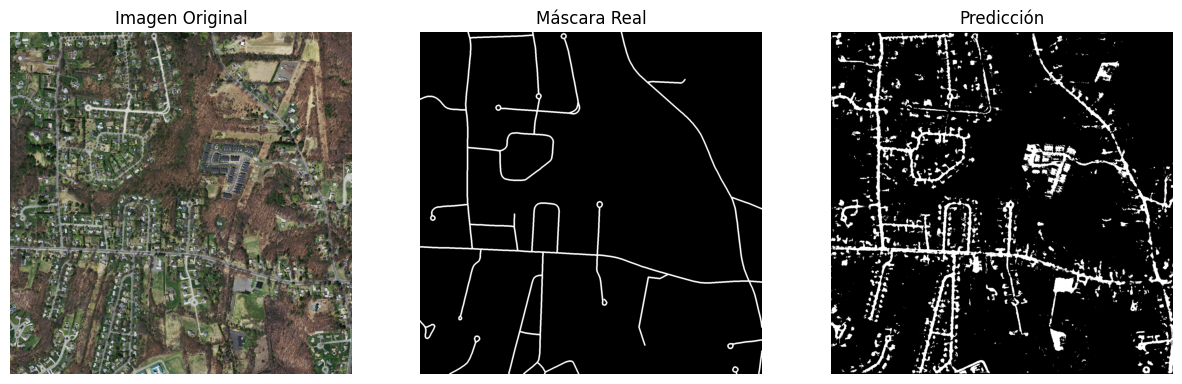

In [ ]:

# Entrenar modelo
model = train_svm_model(X_train, Y_train)

# Evaluar modelo en una imagen completa
predictions = evaluate_on_image(model, images[-1], masks[-1], window_size=16)

# Visualizar resultados
visualize_predictions(images[-1], masks[-1], predictions)


In [9]:
from skimage.feature import local_binary_pattern
from sklearn.preprocessing import StandardScaler

# Parámetros para LBP
RADIUS = 1  # Radio del vecindario
N_POINTS = 8 * RADIUS  # Puntos alrededor del radio

# Función para extraer características de textura con LBP
def extract_lbp_features(image, window_size):
    half = window_size // 2
    lbp_features = []
    for i in range(half, image.shape[0] - half):
        for j in range(half, image.shape[1] - half):
            # Extraer ventana
            window = image[i - half:i + half, j - half:j + half]
            # Calcular LBP
            lbp = local_binary_pattern(window, N_POINTS, RADIUS, method="uniform")
            # Crear un histograma de LBP
            hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, N_POINTS + 3), range=(0, N_POINTS + 2))
            # Normalizar el histograma
            hist = hist.astype("float")
            hist /= (hist.sum() + 1e-6)  # Evitar divisiones por cero
            lbp_features.append(hist)
    return np.array(lbp_features)

# Nota: Aquí trabajarás con imágenes en escala de grises


In [12]:
from skimage.feature import local_binary_pattern

def generate_texture_data(images, masks, ids, window_size, num_samples):
    X, Y = [], []
    
    for img, mask, img_id in zip(images, masks, ids):
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Obtener píxeles blancos y negros
        white_pixels = get_white_pixels(mask, num_samples)
        black_pixels = get_black_pixels(mask, num_samples)
        
        for pixel in white_pixels + black_pixels:
            x, y = pixel
            half = window_size // 2
            if x - half >= 0 and y - half >= 0 and x + half < gray_img.shape[0] and y + half < gray_img.shape[1]:
                window = gray_img[x - half:x + half, y - half:y + half]
                lbp = local_binary_pattern(window, P=8, R=1, method='uniform')
                hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 10))
                hist = hist.astype('float') / (hist.sum() + 1e-6)
                X.append(hist)
                Y.append(1 if mask[x, y] >= 128 else 0)
    return np.array(X), np.array(Y)


In [13]:
# Entrenar modelo SVM
from sklearn.svm import SVC

def train_svm_model(X_train, Y_train):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    model = SVC(kernel='linear', random_state=42)
    model.fit(X_train, Y_train)
    print("Modelo SVM entrenado correctamente.")
    return model, scaler

# Evaluar el modelo en ventanas
def evaluate_model(model, scaler, X_test, Y_test):
    X_test = scaler.transform(X_test)
    predictions = model.predict(X_test)
    print(classification_report(Y_test, predictions))
    print("Matriz de confusión:")
    print(confusion_matrix(Y_test, predictions))


In [14]:
def evaluate_on_image(model, scaler, image, mask, window_size):
    from skimage.feature import local_binary_pattern
    
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rows, cols = gray_img.shape
    predictions = np.zeros((rows, cols), dtype=np.uint8)
    Y_true, Y_pred = [], []
    
    for i in range(window_size // 2, rows - window_size // 2):
        for j in range(window_size // 2, cols - window_size // 2):
            window = gray_img[i - window_size//2:i + window_size//2,
                              j - window_size//2:j + window_size//2]
            lbp = local_binary_pattern(window, P=8, R=1, method='uniform')
            hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 10))
            hist = hist.astype('float') / (hist.sum() + 1e-6)
            hist = scaler.transform([hist])
            pred = model.predict(hist)[0]
            predictions[i, j] = pred
            Y_true.append(1 if mask[i, j] >= 128 else 0)
            Y_pred.append(pred)
    
    print(classification_report(Y_true, Y_pred))
    print("Matriz de confusión:")
    print(confusion_matrix(Y_true, Y_pred))
    return predictions


In [23]:
# Entrenar el modelo
X_train, Y_train = generate_texture_data(images[:-1], masks[:-1], ids[:-1], window_size=16, num_samples=100)
model, scaler = train_svm_model(X_train, Y_train)

Modelo SVM entrenado correctamente.


              precision    recall  f1-score   support

           0       0.99      0.69      0.81   2125714
           1       0.08      0.71      0.14     76542

    accuracy                           0.69   2202256
   macro avg       0.53      0.70      0.47   2202256
weighted avg       0.95      0.69      0.79   2202256

Matriz de confusión:
[[1458979  666735]
 [  22011   54531]]


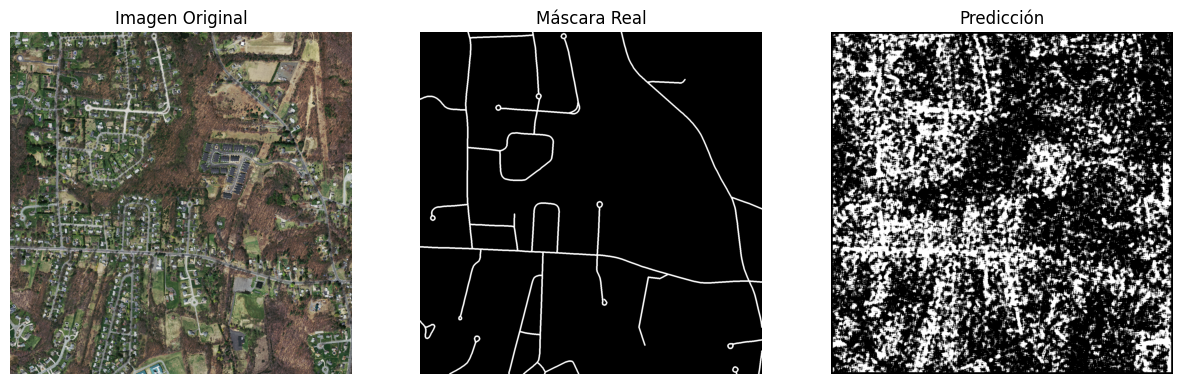

In [ ]:
# Evaluar en la última imagen
test_image, test_mask = images[-1], masks[-1]
predictions = evaluate_on_image(model, scaler, test_image, test_mask, window_size=16)


# Visualizar resultados
visualize_predictions(test_image, test_mask, predictions)

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

def train_rf_model(X_train, Y_train):
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    
    model = RandomForestClassifier(n_estimators=100, criterion='gini', bootstrap= True, random_state=42)
    model.fit(X_train, Y_train)
    return model, scaler


              precision    recall  f1-score   support

           0       0.98      0.64      0.78   2125714
           1       0.07      0.72      0.12     76542

    accuracy                           0.64   2202256
   macro avg       0.53      0.68      0.45   2202256
weighted avg       0.95      0.64      0.75   2202256

Matriz de confusión:
[[1364834  760880]
 [  21085   55457]]


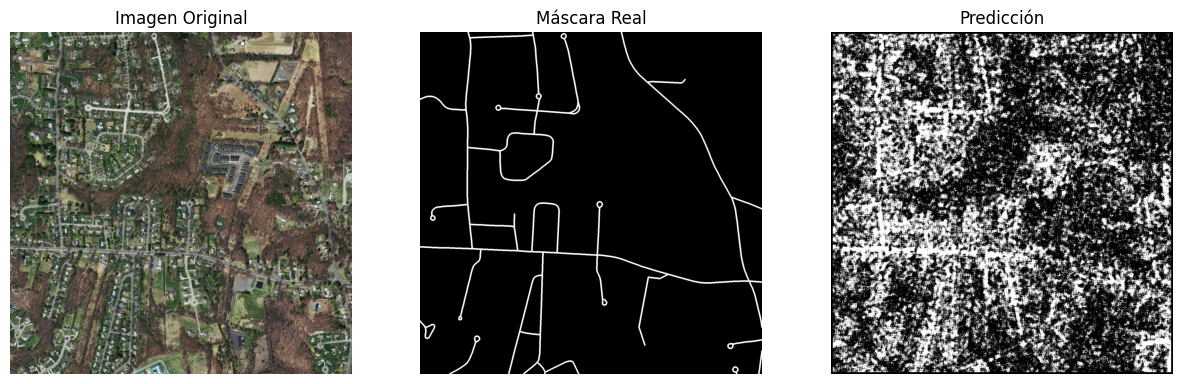

In [20]:
model, scaler = train_rf_model(X_train, Y_train)
predictions = evaluate_on_image(model, scaler, test_image, test_mask, window_size=16)
visualize_predictions(test_image, test_mask, predictions)

In [24]:
# Entrenar el modelo
from imblearn.over_sampling import SMOTE

X_train, Y_train = generate_texture_data(images[:-1], masks[:-1], ids[:-1], window_size=16, num_samples=100)
smote = SMOTE(random_state=42)
X_train_balanced, Y_train_balanced = smote.fit_resample(X_train, Y_train)

model, scaler = train_svm_model(X_train_balanced, Y_train_balanced)

Modelo SVM entrenado correctamente.


              precision    recall  f1-score   support

           0       0.99      0.69      0.81   2125714
           1       0.08      0.71      0.14     76542

    accuracy                           0.69   2202256
   macro avg       0.53      0.70      0.48   2202256
weighted avg       0.95      0.69      0.79   2202256

Matriz de confusión:
[[1470375  655339]
 [  21935   54607]]


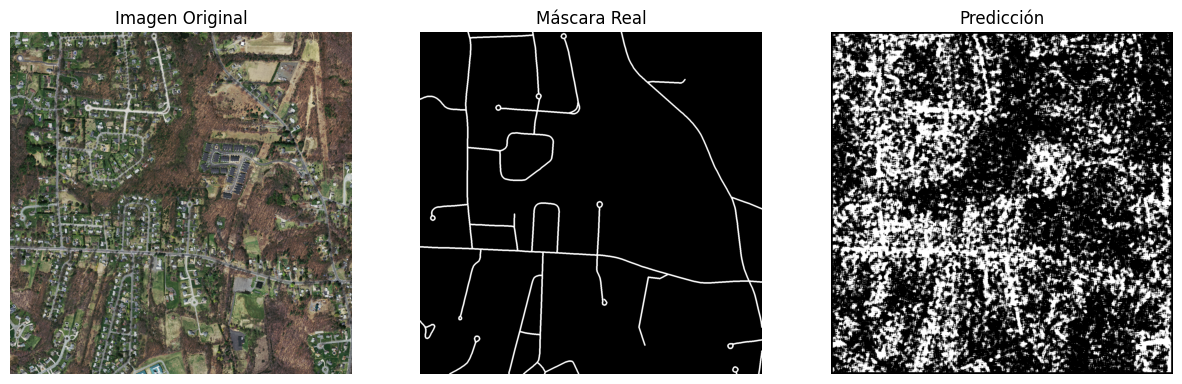

In [ ]:
# Evaluar en la última imagen
test_image, test_mask = images[-1], masks[-1]
predictions = evaluate_on_image(model, scaler, test_image, test_mask, window_size=16)

# Visualizar resultados
visualize_predictions(test_image, test_mask, predictions)

#  caracteristica: Orientación

In [ ]:
"""import cv2
import numpy as np

def compute_orientation(image_gray):
    # Calcular gradientes en X e Y
    grad_x = cv2.Sobel(image_gray, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(image_gray, cv2.CV_64F, 0, 1, ksize=3)

    # Magnitud y ángulo de los gradientes
    magnitude = np.sqrt(grad_x**2 + grad_y**2)
    angle = np.arctan2(grad_y, grad_x)  # Ángulo en radianes

    return magnitude, angle
def orientation_histogram(angle, magnitude, num_bins=8):
    bins = np.linspace(-np.pi, np.pi, num_bins + 1)
    hist, _ = np.histogram(angle, bins=bins, weights=magnitude)
    return hist / np.sum(hist)  # Normalizar
"""